
Model: Multinomial Naive Bayes
Accuracy: 0.95138651925658
Classification Report:
               precision    recall  f1-score   support

         1.0       0.97      0.97      0.97     61160
         2.0       0.73      0.31      0.43      1821
         3.0       0.91      0.96      0.93     24937

    accuracy                           0.95     87918
   macro avg       0.87      0.74      0.78     87918
weighted avg       0.95      0.95      0.95     87918



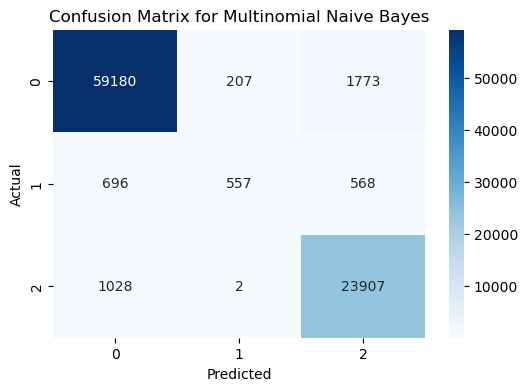


Model: Logistic Regression
Accuracy: 0.9378625537432608
Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      0.93      0.96     61160
         2.0       0.30      0.87      0.44      1821
         3.0       0.96      0.96      0.96     24937

    accuracy                           0.94     87918
   macro avg       0.75      0.92      0.79     87918
weighted avg       0.97      0.94      0.95     87918



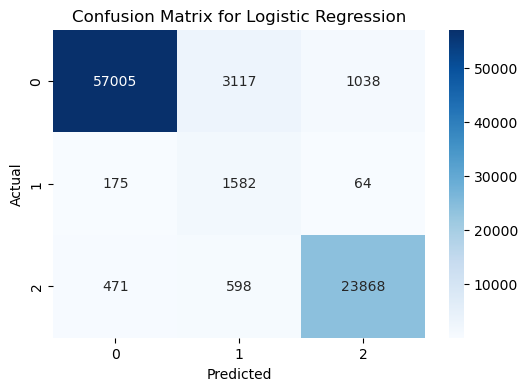

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# --- Load Dataset Efficiently ---
def load_data(filename, chunk_size=10000):
    chunks = pd.read_csv(
        filename, 
        low_memory=True, 
        encoding="ISO-8859-1",  # Use "utf-8" if needed
        engine="python", 
        usecols=['Consumer complaint narrative', 'Product'],  # Load only necessary columns
        on_bad_lines="skip",  # Skip bad rows
        chunksize=chunk_size
    )
    return pd.concat(chunks, ignore_index=True)

df = load_data("complaints.csv")

# --- Drop missing values and reset index ---
df.dropna(subset=['Consumer complaint narrative', 'Product'], inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Map Product Categories to Numbers ---
category_mapping = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df['Product'] = df['Product'].map(category_mapping)
df.dropna(subset=['Product'], inplace=True)  # Remove unmapped categories
df.reset_index(drop=True, inplace=True)

# --- Text Cleaning Function ---
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub("\d+", "", text)  # Remove numbers
    text = " ".join(text.split())  # Remove extra spaces
    return text if len(text) > 3 else ""  # Remove very short complaints

df['Cleaned_Complaint'] = df['Consumer complaint narrative'].apply(clean_text)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    df['Cleaned_Complaint'], df['Product'], test_size=0.2, random_state=42
)

# --- Text Vectorization ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- Model Training & Evaluation Function ---
def train_and_evaluate(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\nModel: {model_name}")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    return model

# --- Train and Evaluate Models ---
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced")
}

trained_models = {}
for name, model in models.items():
    trained_models[name] = train_and_evaluate(model, name)

# --- Save Best Model (Example: Logistic Regression) ---
joblib.dump(trained_models["Logistic Regression"], "logistic_regression.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("\nModel and Vectorizer Saved Successfully!")
